<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/Tweet_Analysis_MultiModel_NN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-02 13:18:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-02 13:18:38 (71.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback,compare_historys, plot_loss_curves, calculate_results

## Download and Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

401 - Unauthorized


In [ ]:
!mkdir sentiment140_unpacked
!mv sentiment140.zip sentiment140_unpacked

mkdir: cannot create directory ‘sentiment140_unpacked’: File exists
mv: cannot stat 'sentiment140.zip': No such file or directory


In [ ]:
%cd sentiment140_unpacked/

/content/gdrive/My Drive/kaggle_dataset/sentiment140_unpacked


In [ ]:
# !unzip sentiment140.zip

## Create a pandas dataframe and preprocess the data



In [ ]:
import pandas as pd

sentiment_df = pd.read_csv('/content/gdrive/MyDrive/kaggle_dataset/sentiment140_unpacked/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [ ]:
sentiment_df = sentiment_df.drop(['Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', '1467810369'], axis = 1)

In [ ]:
sentiment_df.columns


Index(['0', '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'], dtype='object')

In [ ]:
sentiment_df.rename(columns = {'0' : 'Label',
                               "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'Text'}, inplace = True)

In [ ]:
sentiment_df.head()

,Label,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [ ]:
first_col = sentiment_df.pop('Text')

In [ ]:
sentiment_df.insert(0, 'Text', first_col)

In [ ]:
sentiment_df.head()

,Text,Label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [ ]:
sentiment_df = sentiment_df.sample(frac = 1, random_state = 42)

In [ ]:
sentiment_df

,Text,Label
541200,@Nkluvr4eva My poor little dumpling In Holmde...,0
750,I'm off too bed. I gotta wake up hella early t...,0
766711,I havent been able to listen to it yet My spe...,0
285055,now remembers why solving a relatively big equ...,0
705995,"Ate too much, feel sick",0
...,...,...
259178,I didn't. The link was wrong,0
1414414,@tommcfly yes!! mcfly twitter profile is an ex...,4
131932,@SarahFTW I know sometimes i just pretend i h...,0
671155,Cant believe you came and asked me that...,0


### Split data into `Train`, `Test` and `Validation`

### Split DataFrame to `trainval` and `test`

In [ ]:
from sklearn.model_selection import train_test_split

trainval_sentences, test_sentences, trainval_labels, test_labels = train_test_split(sentiment_df['Text'].to_numpy(),
                                                                                    sentiment_df['Label'].to_numpy(),
                                                                                    test_size = 0.15,
                                                                                    random_state = 42)

### Split `trainval` to `train` and `validation`

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(trainval_sentences,
                                                                            trainval_labels,
                                                                            test_size = 0.15,
                                                                            random_state = 42)

In [ ]:
len(train_sentences), len(train_labels)

(1155999, 1155999)

In [ ]:
len(test_sentences), len(test_labels)

(240000, 240000)

In [ ]:
len(val_sentences), len(val_labels)

(204000, 204000)

## Visualize our dataset

In [ ]:
import random
rand_id = random.randint(0, len(sentiment_df)-10)
for row in sentiment_df[['Text', 'Label']][rand_id : rand_id + 10].itertuples():
  _, text, target = row
  print(f'Target : {target}', '[Positive]' if target ==  4 else '[Negative]')
  print(f'Text : {text}')
  print(f'-----\n')

Target : 0 [Negative]
Text : @makeupblogger Don't count on it 
-----

Target : 0 [Negative]
Text : I've - imojonty:  whats wrongggg? Â itâs just hit me that my driving test is SOON and i did a mock one with... http://tumblr.com/xnu21qsa1
-----

Target : 0 [Negative]
Text : @ArsenalGirl LOL I have shouted at my TV many times due to his inability to stay onside 
-----

Target : 4 [Positive]
Text : @toricrzy Um yummy, I'm hating you right now 
-----

Target : 0 [Negative]
Text : sad that runeaddict is down 
-----

Target : 4 [Positive]
Text : @wiccabuffy There was an alliance between Elizabeth I &amp; King of Morocco after Spanish Armada. Morocco sought her help to invade Spain. 
-----

Target : 0 [Negative]
Text : some one stole 1 box of cigarettes from our room.... please return it to me 
-----

Target : 0 [Negative]
Text : @prettylanisax3 awww who is yur 1 and onli friend...????? 
-----

Target : 4 [Positive]
Text : OOOH. im geting a mcflurry n a fry!!! ahahahaha! off to clean the ki

### Converting `train`, `val`, `test` dataframes into datasets

In [ ]:
frames_train = [pd.DataFrame(train_sentences), pd.DataFrame(train_labels)]
frames_val = [pd.DataFrame(val_sentences), pd.DataFrame(val_labels)]
frames_test = [pd.DataFrame(test_sentences), pd.DataFrame(test_labels)]

train_df = pd.concat(frames_train, axis = 1)
val_df = pd.concat(frames_val, axis = 1)
test_df = pd.concat(frames_test, axis = 1)

train_df.columns = ['Text', 'Label']
val_df.columns = ['Text', 'Label']
test_df.columns = ['Text', 'Label']

In [ ]:
train_df.Label.value_counts()

4    578220
0    577779
Name: Label, dtype: int64

## Model_0 Getting a Baseline


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the model
model_0.fit(X = train_sentences,
            y = train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our Baseline Model
model_0.score(X = val_sentences,
              y = val_labels)

0.7705245098039216

In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)

In [ ]:
RESULTS = {}
RESULTS['model_0'] = baseline_results

## Preparing data for Deep Sequence models

### Create Text Vectorizing and Embedding Layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [ ]:
sent_lens[:10]

[26, 10, 5, 11, 18, 17, 5, 19, 26, 15]

In [ ]:
average_sent_lens = np.mean(sent_lens)
average_sent_lens

13.174920566540283

(array([4.3110e+03, 1.8171e+04, 3.7588e+04, 4.9260e+04, 5.8573e+04,
        6.2983e+04, 6.4575e+04, 6.4328e+04, 6.2677e+04, 6.0320e+04,
        5.8087e+04, 5.4993e+04, 5.1852e+04, 4.8882e+04, 4.5791e+04,
        4.3271e+04, 4.0543e+04, 3.8841e+04, 3.7516e+04, 0.0000e+00,
        3.7210e+04, 3.4925e+04, 3.4475e+04, 3.2906e+04, 3.0753e+04,
        2.7020e+04, 2.1461e+04, 1.5368e+04, 9.6030e+03, 5.3220e+03,
        2.6050e+03, 1.1210e+03, 4.2000e+02, 1.6000e+02, 5.7000e+01,
        1.4000e+01, 5.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  , 20.95, 21.9

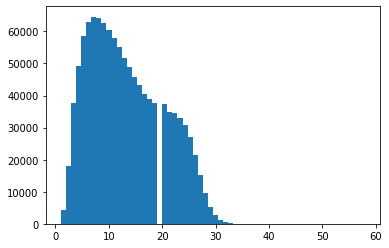

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins = 60)

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 98))
output_seq_len

27

### Create Text Vectorizer Layer

In [ ]:
max_vocab_length = 120000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_vocab_length,
                                                    output_sequence_length = output_seq_len)

In [ ]:
# Adapt text vectorizer to train sentence

text_vectorizer.adapt(train_sentences)

In [ ]:
# Test vectorizing layer

import random
target_sent = random.choice(train_sentences)
print(f'Target Sentence:\n {target_sent}')
print(f'Length of text: {len(target_sent)}')
print(f'After Vectorizing:\n {text_vectorizer([target_sent])}')

Target Sentence:
 @gfalcone601 my hamster is only just turned one 
Length of text: 48
After Vectorizing:
 [[2644    6 6161    9  111   21  938   56    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Most common and Least common words in our vocab

vocab_sentiment140 = text_vectorizer.get_vocabulary()
print(f'No of words in our Vocab: {len(vocab_sentiment140)}')
print(f'Most common words in Vocab: {vocab_sentiment140[:5]}')
print(f'Least common words in Vocab: {vocab_sentiment140[-20:]}')

No of words in our Vocab: 120000
Most common words in Vocab: ['', '[UNK]', 'i', 'to', 'the']
Least common words in Vocab: ['whoknows1970', 'whoknows', 'whoisthisjoant', 'whoissuresh', 'whoisright', 'whoisray', 'whoiskenan', 'whoisjohnlai', 'whoisbarbie', 'whoisb', 'whoisandybarnes', 'whoisalexparker', 'whohooo', 'whoeva', 'whocares', 'whoaw', 'whoand', 'whoamiriam', 'whoak', 'whoaitsjordan']


### Create Text Embedding Layer

In [ ]:
token_embed = layers.Embedding(input_dim = len(vocab_sentiment140),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

In [ ]:
# Test embedding layer

print(f'Before Vectorisation :\n {target_sent}\n')
vectorized_sent = text_vectorizer(target_sent)
print(f'After Vectorizing:\n {vectorized_sent}\n')
print(f'After Embedding:\n {token_embed(vectorized_sent)}')

Before Vectorisation :
 @gfalcone601 my hamster is only just turned one 

After Vectorizing:
 [2644    6 6161    9  111   21  938   56    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

After Embedding:
 [[ 0.00173234  0.0116371  -0.00732322 ... -0.03158253  0.0430929
  -0.0137372 ]
 [-0.0386923   0.03040757  0.00044774 ... -0.01650609 -0.02159954
  -0.01647731]
 [ 0.01154841 -0.01564212  0.0261527  ...  0.03159558  0.00965928
   0.04622406]
 ...
 [ 0.01553795 -0.04226365 -0.02134947 ...  0.03587123  0.00279498
   0.02799643]
 [ 0.01553795 -0.04226365 -0.02134947 ...  0.03587123  0.00279498
   0.02799643]
 [ 0.01553795 -0.04226365 -0.02134947 ...  0.03587123  0.00279498
   0.02799643]]


## Creating Datasets for faster processing


In [ ]:
# Turn datasets into prefetched
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, tf.one_hot(train_labels,depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, tf.one_hot(test_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, tf.one_hot(val_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)

## Model_1: Conv1D + Embedding

In [ ]:
# Create the model
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/3
3612/3612 [==============================] - 57s 12ms/step - loss: 0.4911 - accuracy: 0.7681 - val_loss: 0.4705 - val_accuracy: 0.7861
Epoch 2/3
3612/3612 [==============================] - 44s 12ms/step - loss: 0.4544 - accuracy: 0.7925 - val_loss: 0.4553 - val_accuracy: 0.7946


In [ ]:
model_1.evaluate(val_dataset)

6375/6375 [==============================] - 17s 3ms/step - loss: 0.4501 - accuracy: 0.7962


[0.450056791305542, 0.7961961030960083]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)

In [ ]:
model_1_preds = np.round(model_1_pred_probs)

In [ ]:
model_1_results = calculate_results(y_true = tf.one_hot(val_labels, depth = 1),
                                    y_pred = model_1_preds)

In [ ]:
model_1_results

{'accuracy': 79.61960784313725,
 'precision': 0.7969639262565213,
 'recall': 0.7961960784313725,
 'f1': 0.7960639783297523}

In [ ]:
RESULTS['model_1'] = model_1_results

In [ ]:
RESULTS

{'model_0': {'accuracy': 77.05245098039217,
  'precision': 0.7728593367513529,
  'recall': 0.7705245098039216,
  'f1': 0.7700319671555375},
 'model_1': {'accuracy': 79.61960784313725,
  'precision': 0.7969639262565213,
  'recall': 0.7961960784313725,
  'f1': 0.7960639783297523}}

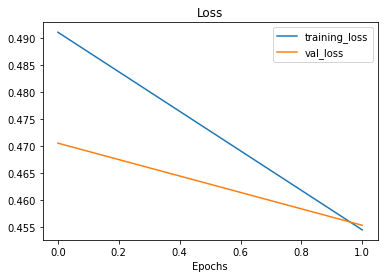

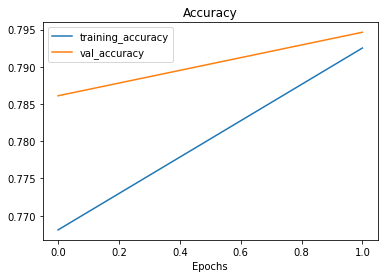

In [ ]:
plot_loss_curves(model_1_history)

## Model_2 Feature Extraction Model

In [ ]:
# Downloading Universal Sentence Encoder

import tensorflow_hub as hub

hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable = False,
                                     name = 'USE')

In [ ]:
random_sent = random.choice(train_sentences)
print(f'Sentence before Embedding Layer: {random_sent}\n')
print(f'Sentence after Embedding Layer: {hub_embedding_layer([random_sent])}')

Sentence before Embedding Layer: bye for now.. see you tomorrow... take care 

Sentence after Embedding Layer: [[ 4.2438552e-02 -7.4418813e-02 -6.2369395e-02 -9.2803016e-03
  -6.9360070e-02 -3.9345589e-02 -4.5571093e-02 -2.0315224e-02
  -5.1395040e-02 -9.0845674e-03 -5.1141670e-03  3.9848555e-03
  -2.9839013e-02 -2.1161804e-02  7.0902407e-02 -9.0821058e-02
  -4.1446615e-02  5.7394125e-02 -6.3911388e-03  5.3728700e-02
  -3.4088228e-02  3.4691662e-02  8.1937626e-02 -4.1656818e-02
   3.4957822e-02  2.6190858e-02  2.8295636e-02 -2.3845928e-02
  -6.0477715e-02  1.6859865e-02  1.4095489e-02 -4.4178762e-02
  -5.3342776e-03  6.5835030e-03  2.9364318e-02 -1.6997447e-02
   2.3125151e-02  4.2530904e-03  1.3670823e-02  3.4390062e-02
   5.4802570e-02 -1.6487999e-02 -2.4891153e-02  2.8531486e-02
   4.4405125e-02  3.9680768e-02 -8.5650541e-02 -2.3879379e-02
   1.8056337e-02  1.3583407e-02 -2.4695996e-02 -8.2969554e-02
  -3.6911689e-02 -5.2484833e-02 -2.3118726e-03 -3.0194754e-02
   4.2684533e-02 -1.2

In [ ]:
len(hub_embedding_layer([random_sent])[0]) # Length is 512 because the input is a variable length English text and the ouput is 512 dimensional feature vector

512

In [ ]:
# Create model_2

inputs = layers.Input(shape = [], dtype = tf.string)
embedding = hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu', )(embedding)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
# Fit the model
model_2_hist  = model_2.fit(train_dataset,
                            epochs = 3,
                            steps_per_epoch = int(0.1 * len(train_dataset)),
                            validation_data = val_dataset,
                            validation_steps = int(0.1 * len(val_dataset)),
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/3
3612/3612 [==============================] - 42s 11ms/step - loss: 0.4663 - accuracy: 0.7796 - val_loss: 0.4580 - val_accuracy: 0.7810
Epoch 2/3
3612/3612 [==============================] - 39s 11ms/step - loss: 0.4458 - accuracy: 0.7895 - val_loss: 0.4475 - val_accuracy: 0.7879


In [ ]:
model_2.evaluate(val_dataset)

6375/6375 [==============================] - 58s 9ms/step - loss: 0.4450 - accuracy: 0.7898


[0.444970041513443, 0.7898382544517517]

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)

In [ ]:
model_2_preds = np.round(model_2_pred_probs)

In [ ]:
model_2_results = calculate_results(y_pred = model_2_preds,
                                    y_true = tf.one_hot(val_labels, depth = 1))

In [ ]:
RESULTS['model_2'] = model_2_results

In [ ]:
RESULTS

{'model_0': {'accuracy': 77.05245098039217,
  'precision': 0.7728593367513529,
  'recall': 0.7705245098039216,
  'f1': 0.7700319671555375},
 'model_1': {'accuracy': 79.61960784313725,
  'precision': 0.7969639262565213,
  'recall': 0.7961960784313725,
  'f1': 0.7960639783297523},
 'model_2': {'accuracy': 78.98382352941177,
  'precision': 0.7905284339580059,
  'recall': 0.7898382352941177,
  'f1': 0.7897130690084226}}

## Model_3 with Character Level tokenisation

In [ ]:
def split_char(text):
  return ' '.join((text))

In [ ]:
' '.join('I Love You')

'I   L o v e   Y o u'

In [ ]:
' '.join(list('I Love You'))

'I   L o v e   Y o u'

In [ ]:
train_char = [split_char(sentence) for sentence in train_sentences]

In [ ]:
char_len = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_len)
mean_char_lens

74.08697585378535

(array([1.86540e+04, 6.15180e+04, 9.05650e+04, 1.03559e+05, 1.07025e+05,
        1.15028e+05, 9.51020e+04, 8.55650e+04, 7.64450e+04, 6.94770e+04,
        6.96780e+04, 5.80320e+04, 5.74000e+04, 6.96270e+04, 7.18960e+04,
        5.59100e+03, 5.32000e+02, 1.12000e+02, 3.80000e+01, 3.10000e+01,
        2.20000e+01, 1.60000e+01, 1.70000e+01, 1.60000e+01, 1.80000e+01,
        1.30000e+01, 2.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([  6. ,  15.2,  24.4,  33.6,  42.8,  52. ,  61.2,  70.4,  79.6,
         88.8,  98. , 107.2, 116.4, 125.6, 134.8, 144. , 153.2, 162.4,
        171.6, 180.8, 190. , 199.2, 208.4, 217.6, 226.8, 236. , 245.2,
        254.4, 263.6, 272.8, 282. , 291.2, 300.4, 309.6, 318.8, 328. ,
        337.2, 346.4, 355.6, 364.8, 374. ]),
 <a list of 40 Patch objects>)

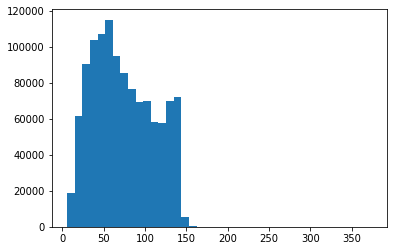

In [ ]:
#  Check distribution of char

import matplotlib.pyplot as plt
plt.hist(char_len, bins = 40)

In [ ]:
output_seq_len = int(np.percentile(char_len, 95))
output_seq_len

136

In [ ]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create Char lvl token vectorizer instance

NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                                    output_sequence_length = output_seq_len,
                                                    name = 'char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_char)

In [ ]:
# Check char vocab stats

char_vocab = char_vectorizer.get_vocabulary()
print(f'Num of diff char {len(char_vocab)}')
print(f'5 most common char {char_vocab[:5]}')
print(f'5 least commom char {char_vocab[-5:]}')

Num of diff char 70
5 most common char ['', '[UNK]', 'e', 't', 'o']
5 least commom char ['¼', '\x83', '¡', '±', '\x84']


In [ ]:
random_train_chars = random.choice(train_char)
print(f'Charified text: {random_train_chars}\n')
print(f'Len of rnaodm_train_char: {len(random_train_chars.split())}')
vectorized_char = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n {vectorized_char}')
print(f'Len of vectorized chars:{len(vectorized_char[0])}')

Charified text: @ w i l w   D u d e !   H e ' s   n o t   m a k i n   w i t h   t h e   p i c s   f a s t   e n o u g h !  

Len of rnaodm_train_char: 44
Vectorized chars:
 [[17  6 11 17 12 14 12  2 10  2  8  7  4  3 13  5 22  6  7 17  6  3 10  3
  10  2 19  6 18  8 20  5  8  3  2  7  4 14 16 10  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Len of vectorized chars:136


In [ ]:
# Create a char lvl embedding

char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 20,
                              mask_zero = True,
                              name = 'char_embed')

In [ ]:
print(f'Charified text: {random_train_chars}\n')
embeded_char = char_embed(char_vectorizer([random_train_chars]))
print(f'Embeded Char : {embeded_char}\n')
print(f'Embeded Char Shape : {embeded_char.shape}')

Charified text: @ w i l w   D u d e !   H e ' s   n o t   m a k i n   w i t h   t h e   p i c s   f a s t   e n o u g h !  

Embeded Char : [[[-0.03739623 -0.03048164  0.00390618 ... -0.03021611 -0.0382316
    0.02939797]
  [-0.02488065 -0.02940455  0.01220487 ...  0.01290289  0.04521009
   -0.04786528]
  [-0.0087915   0.02516934  0.03895325 ...  0.00922092  0.03216458
    0.04843843]
  ...
  [ 0.00800379 -0.00518304 -0.04104519 ... -0.03062329  0.03941322
    0.02021671]
  [ 0.00800379 -0.00518304 -0.04104519 ... -0.03062329  0.03941322
    0.02021671]
  [ 0.00800379 -0.00518304 -0.04104519 ... -0.03062329  0.03941322
    0.02021671]]]

Embeded Char Shape : (1, 136, 20)


In [ ]:
# Create the model_3

inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeds = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 3, padidng = 'same', activation = 'relu')(char_embeds)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

